# 1. Import and Install Dependencies

In [28]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [4]:
# Holistic model
mp_holistic = mp.solutions.holistic

# Drawing utilities
mp_drawing = mp.solutions.drawing_utils

In [5]:
def mediapipe_detection(image,model):
    
    # Color conversion BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Image is no longer writeable
    image.flags.writeable = False
    
    # Make prediction
    results = model.process(image)
    
    # Image is now writeable
    image.flags.writeable = True
    
    # Color conversion RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    return image, results

In [6]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)
                             )
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             )
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             )    
                            

In [8]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image,results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [11]:
cap.release()
cv2.destroyAllWindows()

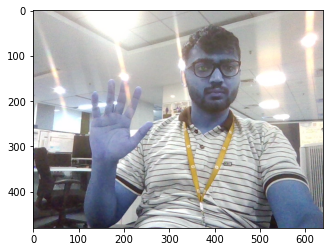

In [35]:
plt.imshow(frame)

In [36]:
draw_landmarks(frame, results)

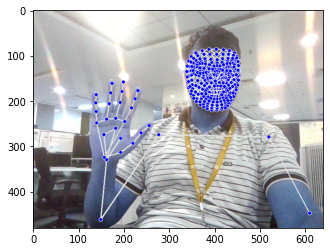

In [37]:
plt.imshow(frame)

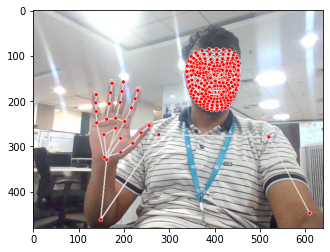

In [38]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [39]:
results

mediapipe.python.solution_base.SolutionOutputs

In [12]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face, lh, rh])

In [42]:
extract_keypoints(results).shape

(1662,)

# 4. Setup Folders for Collection

In [20]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['hello','thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [21]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: 
    
    # Loop through actions
    for action in actions:
        
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                
                # Read feed
                ret, frame = cap.read()
                
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)
                
                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # Apply collection logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT-HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                
                # Export keypoints    
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
                
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [24]:
label_map = {label:num for num, label in enumerate(actions)}

In [25]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [26]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [49]:
np.array(sequences).shape

(90, 30, 1662)

In [50]:
np.array(labels).shape

(90,)

In [51]:
X = np.array(sequences)

In [52]:
X.shape

(90, 30, 1662)

In [53]:
y = to_categorical(labels).astype(int)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [55]:
X_train.shape

(85, 30, 1662)

In [56]:
X_test.shape

(5, 30, 1662)

In [57]:
y_train.shape

(85, 3)

In [58]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [16]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [27]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape = (30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [28]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [63]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 3s 76ms/step - loss: 1.1479 - categorical_accuracy: 0.3059
Epoch 2/2000
3/3 [==============================] - 0s 67ms/step - loss: 1.5200 - categorical_accuracy: 0.3294
Epoch 3/2000
3/3 [==============================] - 0s 65ms/step - loss: 0.8715 - categorical_accuracy: 0.3529
Epoch 4/2000
3/3 [==============================] - 0s 64ms/step - loss: 1.1549 - categorical_accuracy: 0.3294
Epoch 5/2000
3/3 [==============================] - 0s 66ms/step - loss: 2.8927 - categorical_accuracy: 0.4000
Epoch 6/2000
3/3 [==============================] - 0s 67ms/step - loss: 2.6043 - categorical_accuracy: 0.4588
Epoch 7/2000
3/3 [==============================] - 0s 61ms/step - loss: 1.5103 - categorical_accuracy: 0.3882
Epoch 8/2000
3/3 [==============================] - 0s 66ms/step - loss: 1.2623 - categorical_accuracy: 0.3176
Epoch 9/2000
3/3 [==============================] - 0s 65ms/step - loss: 1.4432 - categorical_accuracy: 0.3412
E

3/3 [==============================] - 0s 91ms/step - loss: 0.4323 - categorical_accuracy: 0.7529
Epoch 75/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.3775 - categorical_accuracy: 0.8588
Epoch 76/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.3568 - categorical_accuracy: 0.8471
Epoch 77/2000
3/3 [==============================] - 0s 82ms/step - loss: 0.2984 - categorical_accuracy: 0.9176
Epoch 78/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.2341 - categorical_accuracy: 0.8941
Epoch 79/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.2014 - categorical_accuracy: 0.9412
Epoch 80/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.2183 - categorical_accuracy: 0.8824
Epoch 81/2000
3/3 [==============================] - 0s 85ms/step - loss: 0.2357 - categorical_accuracy: 0.9059
Epoch 82/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.4305 - categorical_accuracy: 0.7765
Epoch 

3/3 [==============================] - 0s 75ms/step - loss: 0.0545 - categorical_accuracy: 0.9882
Epoch 147/2000
3/3 [==============================] - 0s 80ms/step - loss: 0.0176 - categorical_accuracy: 1.0000
Epoch 148/2000
3/3 [==============================] - 0s 75ms/step - loss: 0.0216 - categorical_accuracy: 1.0000
Epoch 149/2000
3/3 [==============================] - 0s 85ms/step - loss: 0.0385 - categorical_accuracy: 0.9882
Epoch 150/2000
3/3 [==============================] - 0s 73ms/step - loss: 0.0197 - categorical_accuracy: 1.0000
Epoch 151/2000
3/3 [==============================] - 0s 77ms/step - loss: 0.0214 - categorical_accuracy: 1.0000
Epoch 152/2000
3/3 [==============================] - 0s 68ms/step - loss: 0.0349 - categorical_accuracy: 0.9882
Epoch 153/2000
3/3 [==============================] - 0s 71ms/step - loss: 0.0196 - categorical_accuracy: 0.9882
Epoch 154/2000
3/3 [==============================] - 0s 77ms/step - loss: 0.0356 - categorical_accuracy: 0.976

3/3 [==============================] - 0s 73ms/step - loss: 1.1939e-04 - categorical_accuracy: 1.0000
Epoch 217/2000
3/3 [==============================] - 0s 95ms/step - loss: 1.1608e-04 - categorical_accuracy: 1.0000
Epoch 218/2000
3/3 [==============================] - 0s 76ms/step - loss: 1.1339e-04 - categorical_accuracy: 1.0000
Epoch 219/2000
3/3 [==============================] - 0s 84ms/step - loss: 1.1020e-04 - categorical_accuracy: 1.0000
Epoch 220/2000
3/3 [==============================] - 0s 89ms/step - loss: 1.0836e-04 - categorical_accuracy: 1.0000
Epoch 221/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.0628e-04 - categorical_accuracy: 1.0000
Epoch 222/2000
3/3 [==============================] - 0s 86ms/step - loss: 1.0318e-04 - categorical_accuracy: 1.0000
Epoch 223/2000
3/3 [==============================] - 0s 85ms/step - loss: 1.0133e-04 - categorical_accuracy: 1.0000
Epoch 224/2000
3/3 [==============================] - 0s 79ms/step - loss: 9.86

3/3 [==============================] - 0s 67ms/step - loss: 3.0955e-05 - categorical_accuracy: 1.0000
Epoch 287/2000
3/3 [==============================] - 0s 72ms/step - loss: 3.0703e-05 - categorical_accuracy: 1.0000
Epoch 288/2000
3/3 [==============================] - 0s 70ms/step - loss: 3.0317e-05 - categorical_accuracy: 1.0000
Epoch 289/2000
3/3 [==============================] - 0s 69ms/step - loss: 3.0162e-05 - categorical_accuracy: 1.0000
Epoch 290/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.9839e-05 - categorical_accuracy: 1.0000
Epoch 291/2000
3/3 [==============================] - 0s 68ms/step - loss: 2.9528e-05 - categorical_accuracy: 1.0000
Epoch 292/2000
3/3 [==============================] - 0s 70ms/step - loss: 2.9406e-05 - categorical_accuracy: 1.0000
Epoch 293/2000
3/3 [==============================] - 0s 70ms/step - loss: 2.8906e-05 - categorical_accuracy: 1.0000
Epoch 294/2000
3/3 [==============================] - 0s 72ms/step - loss: 2.86

3/3 [==============================] - 0s 71ms/step - loss: 1.7222e-05 - categorical_accuracy: 1.0000
Epoch 357/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.7065e-05 - categorical_accuracy: 1.0000
Epoch 358/2000
3/3 [==============================] - 0s 76ms/step - loss: 1.7022e-05 - categorical_accuracy: 1.0000
Epoch 359/2000
3/3 [==============================] - 0s 67ms/step - loss: 1.6799e-05 - categorical_accuracy: 1.0000
Epoch 360/2000
3/3 [==============================] - 0s 69ms/step - loss: 1.6799e-05 - categorical_accuracy: 1.0000
Epoch 361/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.6670e-05 - categorical_accuracy: 1.0000
Epoch 362/2000
3/3 [==============================] - 0s 71ms/step - loss: 1.6524e-05 - categorical_accuracy: 1.0000
Epoch 363/2000
3/3 [==============================] - 0s 71ms/step - loss: 1.6395e-05 - categorical_accuracy: 1.0000
Epoch 364/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.63

3/3 [==============================] - 0s 70ms/step - loss: 1.1138e-05 - categorical_accuracy: 1.0000
Epoch 427/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.1104e-05 - categorical_accuracy: 1.0000
Epoch 428/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.1040e-05 - categorical_accuracy: 1.0000
Epoch 429/2000
3/3 [==============================] - 0s 69ms/step - loss: 1.0935e-05 - categorical_accuracy: 1.0000
Epoch 430/2000
3/3 [==============================] - 0s 66ms/step - loss: 1.0926e-05 - categorical_accuracy: 1.0000
Epoch 431/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.0877e-05 - categorical_accuracy: 1.0000
Epoch 432/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.0803e-05 - categorical_accuracy: 1.0000
Epoch 433/2000
3/3 [==============================] - 0s 69ms/step - loss: 1.0712e-05 - categorical_accuracy: 1.0000
Epoch 434/2000
3/3 [==============================] - 0s 68ms/step - loss: 1.07

3/3 [==============================] - 0s 69ms/step - loss: 7.5906e-06 - categorical_accuracy: 1.0000
Epoch 497/2000
3/3 [==============================] - 0s 81ms/step - loss: 7.5289e-06 - categorical_accuracy: 1.0000
Epoch 498/2000
3/3 [==============================] - 0s 70ms/step - loss: 7.5037e-06 - categorical_accuracy: 1.0000
Epoch 499/2000
3/3 [==============================] - 0s 69ms/step - loss: 7.4532e-06 - categorical_accuracy: 1.0000
Epoch 500/2000
3/3 [==============================] - 0s 70ms/step - loss: 7.4476e-06 - categorical_accuracy: 1.0000
Epoch 501/2000
3/3 [==============================] - 0s 68ms/step - loss: 7.4125e-06 - categorical_accuracy: 1.0000
Epoch 502/2000
3/3 [==============================] - 0s 72ms/step - loss: 7.3480e-06 - categorical_accuracy: 1.0000
Epoch 503/2000
3/3 [==============================] - 0s 69ms/step - loss: 7.3032e-06 - categorical_accuracy: 1.0000
Epoch 504/2000
3/3 [==============================] - 0s 71ms/step - loss: 7.28

3/3 [==============================] - 0s 71ms/step - loss: 5.1452e-06 - categorical_accuracy: 1.0000
Epoch 567/2000
3/3 [==============================] - 0s 69ms/step - loss: 5.1031e-06 - categorical_accuracy: 1.0000
Epoch 568/2000
3/3 [==============================] - 0s 70ms/step - loss: 5.0652e-06 - categorical_accuracy: 1.0000
Epoch 569/2000
3/3 [==============================] - 0s 72ms/step - loss: 5.0610e-06 - categorical_accuracy: 1.0000
Epoch 570/2000
3/3 [==============================] - 0s 70ms/step - loss: 5.0246e-06 - categorical_accuracy: 1.0000
Epoch 571/2000
3/3 [==============================] - 0s 65ms/step - loss: 5.0035e-06 - categorical_accuracy: 1.0000
Epoch 572/2000
3/3 [==============================] - 0s 72ms/step - loss: 4.9713e-06 - categorical_accuracy: 1.0000
Epoch 573/2000
3/3 [==============================] - 0s 68ms/step - loss: 4.9376e-06 - categorical_accuracy: 1.0000
Epoch 574/2000
3/3 [==============================] - 0s 66ms/step - loss: 4.91

3/3 [==============================] - 0s 76ms/step - loss: 3.3138e-06 - categorical_accuracy: 1.0000
Epoch 637/2000
3/3 [==============================] - 0s 74ms/step - loss: 3.2857e-06 - categorical_accuracy: 1.0000
Epoch 638/2000
3/3 [==============================] - 0s 76ms/step - loss: 3.2759e-06 - categorical_accuracy: 1.0000
Epoch 639/2000
3/3 [==============================] - 0s 73ms/step - loss: 3.2549e-06 - categorical_accuracy: 1.0000
Epoch 640/2000
3/3 [==============================] - 0s 72ms/step - loss: 3.2254e-06 - categorical_accuracy: 1.0000
Epoch 641/2000
3/3 [==============================] - 0s 83ms/step - loss: 3.2058e-06 - categorical_accuracy: 1.0000
Epoch 642/2000
3/3 [==============================] - 0s 77ms/step - loss: 3.1904e-06 - categorical_accuracy: 1.0000
Epoch 643/2000
3/3 [==============================] - 0s 75ms/step - loss: 3.1665e-06 - categorical_accuracy: 1.0000
Epoch 644/2000
3/3 [==============================] - 0s 70ms/step - loss: 3.13

3/3 [==============================] - 0s 80ms/step - loss: 2.0685e-06 - categorical_accuracy: 1.0000
Epoch 707/2000
3/3 [==============================] - 0s 68ms/step - loss: 2.0629e-06 - categorical_accuracy: 1.0000
Epoch 708/2000
3/3 [==============================] - 0s 71ms/step - loss: 2.0391e-06 - categorical_accuracy: 1.0000
Epoch 709/2000
3/3 [==============================] - 0s 69ms/step - loss: 2.0321e-06 - categorical_accuracy: 1.0000
Epoch 710/2000
3/3 [==============================] - 0s 71ms/step - loss: 2.0152e-06 - categorical_accuracy: 1.0000
Epoch 711/2000
3/3 [==============================] - 0s 75ms/step - loss: 2.0012e-06 - categorical_accuracy: 1.0000
Epoch 712/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.9914e-06 - categorical_accuracy: 1.0000
Epoch 713/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.9788e-06 - categorical_accuracy: 1.0000
Epoch 714/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.96

3/3 [==============================] - 0s 78ms/step - loss: 1.3491e-06 - categorical_accuracy: 1.0000
Epoch 777/2000
3/3 [==============================] - 0s 71ms/step - loss: 1.3449e-06 - categorical_accuracy: 1.0000
Epoch 778/2000
3/3 [==============================] - 0s 72ms/step - loss: 1.3365e-06 - categorical_accuracy: 1.0000
Epoch 779/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.3281e-06 - categorical_accuracy: 1.0000
Epoch 780/2000
3/3 [==============================] - 0s 77ms/step - loss: 1.3197e-06 - categorical_accuracy: 1.0000
Epoch 781/2000
3/3 [==============================] - 0s 75ms/step - loss: 1.3155e-06 - categorical_accuracy: 1.0000
Epoch 782/2000
3/3 [==============================] - 0s 75ms/step - loss: 1.3098e-06 - categorical_accuracy: 1.0000
Epoch 783/2000
3/3 [==============================] - 0s 75ms/step - loss: 1.3042e-06 - categorical_accuracy: 1.0000
Epoch 784/2000
3/3 [==============================] - 0s 72ms/step - loss: 1.29

3/3 [==============================] - 0s 83ms/step - loss: 9.7748e-07 - categorical_accuracy: 1.0000
Epoch 847/2000
3/3 [==============================] - 0s 77ms/step - loss: 9.7047e-07 - categorical_accuracy: 1.0000
Epoch 848/2000
3/3 [==============================] - 0s 71ms/step - loss: 9.6626e-07 - categorical_accuracy: 1.0000
Epoch 849/2000
3/3 [==============================] - 0s 72ms/step - loss: 9.6065e-07 - categorical_accuracy: 1.0000
Epoch 850/2000
3/3 [==============================] - 0s 72ms/step - loss: 9.5785e-07 - categorical_accuracy: 1.0000
Epoch 851/2000
3/3 [==============================] - 0s 74ms/step - loss: 9.5364e-07 - categorical_accuracy: 1.0000
Epoch 852/2000
3/3 [==============================] - 0s 78ms/step - loss: 9.5084e-07 - categorical_accuracy: 1.0000
Epoch 853/2000
3/3 [==============================] - 0s 69ms/step - loss: 9.4663e-07 - categorical_accuracy: 1.0000
Epoch 854/2000
3/3 [==============================] - 0s 71ms/step - loss: 9.45

3/3 [==============================] - 0s 73ms/step - loss: 7.6853e-07 - categorical_accuracy: 1.0000
Epoch 917/2000
3/3 [==============================] - 0s 71ms/step - loss: 7.6572e-07 - categorical_accuracy: 1.0000
Epoch 918/2000
3/3 [==============================] - 0s 73ms/step - loss: 7.6432e-07 - categorical_accuracy: 1.0000
Epoch 919/2000
3/3 [==============================] - 0s 76ms/step - loss: 7.6292e-07 - categorical_accuracy: 1.0000
Epoch 920/2000
3/3 [==============================] - 0s 71ms/step - loss: 7.6292e-07 - categorical_accuracy: 1.0000
Epoch 921/2000
3/3 [==============================] - 0s 73ms/step - loss: 7.6152e-07 - categorical_accuracy: 1.0000
Epoch 922/2000
3/3 [==============================] - 0s 73ms/step - loss: 7.5731e-07 - categorical_accuracy: 1.0000
Epoch 923/2000
3/3 [==============================] - 0s 74ms/step - loss: 7.5310e-07 - categorical_accuracy: 1.0000
Epoch 924/2000
3/3 [==============================] - 0s 75ms/step - loss: 7.51

3/3 [==============================] - 0s 72ms/step - loss: 6.2829e-07 - categorical_accuracy: 1.0000
Epoch 987/2000
3/3 [==============================] - 0s 83ms/step - loss: 6.2408e-07 - categorical_accuracy: 1.0000
Epoch 988/2000
3/3 [==============================] - 0s 81ms/step - loss: 6.2268e-07 - categorical_accuracy: 1.0000
Epoch 989/2000
3/3 [==============================] - 0s 76ms/step - loss: 6.2128e-07 - categorical_accuracy: 1.0000
Epoch 990/2000
3/3 [==============================] - 0s 79ms/step - loss: 6.1987e-07 - categorical_accuracy: 1.0000
Epoch 991/2000
3/3 [==============================] - 0s 75ms/step - loss: 6.1847e-07 - categorical_accuracy: 1.0000
Epoch 992/2000
3/3 [==============================] - 0s 73ms/step - loss: 6.1567e-07 - categorical_accuracy: 1.0000
Epoch 993/2000
3/3 [==============================] - 0s 72ms/step - loss: 6.1426e-07 - categorical_accuracy: 1.0000
Epoch 994/2000
3/3 [==============================] - 0s 71ms/step - loss: 6.11

3/3 [==============================] - 0s 78ms/step - loss: 5.2451e-07 - categorical_accuracy: 1.0000
Epoch 1056/2000
3/3 [==============================] - 0s 84ms/step - loss: 5.2311e-07 - categorical_accuracy: 1.0000
Epoch 1057/2000
3/3 [==============================] - 0s 82ms/step - loss: 5.2171e-07 - categorical_accuracy: 1.0000
Epoch 1058/2000
3/3 [==============================] - 0s 78ms/step - loss: 5.1750e-07 - categorical_accuracy: 1.0000
Epoch 1059/2000
3/3 [==============================] - 0s 71ms/step - loss: 5.1750e-07 - categorical_accuracy: 1.0000
Epoch 1060/2000
3/3 [==============================] - 0s 76ms/step - loss: 5.1610e-07 - categorical_accuracy: 1.0000
Epoch 1061/2000
3/3 [==============================] - 0s 76ms/step - loss: 5.1329e-07 - categorical_accuracy: 1.0000
Epoch 1062/2000
3/3 [==============================] - 0s 74ms/step - loss: 5.1329e-07 - categorical_accuracy: 1.0000
Epoch 1063/2000
3/3 [==============================] - 0s 72ms/step - lo

3/3 [==============================] - 0s 75ms/step - loss: 4.4738e-07 - categorical_accuracy: 1.0000
Epoch 1125/2000
3/3 [==============================] - 0s 72ms/step - loss: 4.4598e-07 - categorical_accuracy: 1.0000
Epoch 1126/2000
3/3 [==============================] - 0s 76ms/step - loss: 4.4457e-07 - categorical_accuracy: 1.0000
Epoch 1127/2000
3/3 [==============================] - 0s 73ms/step - loss: 4.4317e-07 - categorical_accuracy: 1.0000
Epoch 1128/2000
3/3 [==============================] - 0s 74ms/step - loss: 4.4317e-07 - categorical_accuracy: 1.0000
Epoch 1129/2000
3/3 [==============================] - 0s 73ms/step - loss: 4.4177e-07 - categorical_accuracy: 1.0000
Epoch 1130/2000
3/3 [==============================] - 0s 72ms/step - loss: 4.4037e-07 - categorical_accuracy: 1.0000
Epoch 1131/2000
3/3 [==============================] - 0s 69ms/step - loss: 4.4037e-07 - categorical_accuracy: 1.0000
Epoch 1132/2000
3/3 [==============================] - 0s 74ms/step - lo

3/3 [==============================] - 0s 76ms/step - loss: 3.8567e-07 - categorical_accuracy: 1.0000
Epoch 1194/2000
3/3 [==============================] - 0s 75ms/step - loss: 3.8567e-07 - categorical_accuracy: 1.0000
Epoch 1195/2000
3/3 [==============================] - 0s 75ms/step - loss: 3.8427e-07 - categorical_accuracy: 1.0000
Epoch 1196/2000
3/3 [==============================] - 0s 75ms/step - loss: 3.8287e-07 - categorical_accuracy: 1.0000
Epoch 1197/2000
3/3 [==============================] - 0s 72ms/step - loss: 3.8287e-07 - categorical_accuracy: 1.0000
Epoch 1198/2000
3/3 [==============================] - 0s 69ms/step - loss: 3.8287e-07 - categorical_accuracy: 1.0000
Epoch 1199/2000
3/3 [==============================] - 0s 74ms/step - loss: 3.8146e-07 - categorical_accuracy: 1.0000
Epoch 1200/2000
3/3 [==============================] - 0s 73ms/step - loss: 3.8006e-07 - categorical_accuracy: 1.0000
Epoch 1201/2000
3/3 [==============================] - 0s 73ms/step - lo

3/3 [==============================] - 0s 74ms/step - loss: 3.3659e-07 - categorical_accuracy: 1.0000
Epoch 1263/2000
3/3 [==============================] - 0s 75ms/step - loss: 3.3518e-07 - categorical_accuracy: 1.0000
Epoch 1264/2000
3/3 [==============================] - 0s 81ms/step - loss: 3.3518e-07 - categorical_accuracy: 1.0000
Epoch 1265/2000
3/3 [==============================] - 0s 83ms/step - loss: 3.3518e-07 - categorical_accuracy: 1.0000
Epoch 1266/2000
3/3 [==============================] - 0s 82ms/step - loss: 3.3378e-07 - categorical_accuracy: 1.0000
Epoch 1267/2000
3/3 [==============================] - 0s 82ms/step - loss: 3.3378e-07 - categorical_accuracy: 1.0000
Epoch 1268/2000
3/3 [==============================] - 0s 84ms/step - loss: 3.3238e-07 - categorical_accuracy: 1.0000
Epoch 1269/2000
3/3 [==============================] - 0s 82ms/step - loss: 3.3098e-07 - categorical_accuracy: 1.0000
Epoch 1270/2000
3/3 [==============================] - 0s 76ms/step - lo

3/3 [==============================] - 0s 75ms/step - loss: 2.9451e-07 - categorical_accuracy: 1.0000
Epoch 1332/2000
3/3 [==============================] - 0s 77ms/step - loss: 2.9311e-07 - categorical_accuracy: 1.0000
Epoch 1333/2000
3/3 [==============================] - 0s 72ms/step - loss: 2.9311e-07 - categorical_accuracy: 1.0000
Epoch 1334/2000
3/3 [==============================] - 0s 71ms/step - loss: 2.9171e-07 - categorical_accuracy: 1.0000
Epoch 1335/2000
3/3 [==============================] - 0s 77ms/step - loss: 2.9171e-07 - categorical_accuracy: 1.0000
Epoch 1336/2000
3/3 [==============================] - 0s 80ms/step - loss: 2.9171e-07 - categorical_accuracy: 1.0000
Epoch 1337/2000
3/3 [==============================] - 0s 74ms/step - loss: 2.9031e-07 - categorical_accuracy: 1.0000
Epoch 1338/2000
3/3 [==============================] - 0s 72ms/step - loss: 2.9031e-07 - categorical_accuracy: 1.0000
Epoch 1339/2000
3/3 [==============================] - 0s 71ms/step - lo

3/3 [==============================] - 0s 74ms/step - loss: 2.5805e-07 - categorical_accuracy: 1.0000
Epoch 1401/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 1402/2000
3/3 [==============================] - 0s 74ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 1403/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 1404/2000
3/3 [==============================] - 0s 74ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 1405/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 1406/2000
3/3 [==============================] - 0s 76ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 1407/2000
3/3 [==============================] - 0s 72ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 1408/2000
3/3 [==============================] - 0s 74ms/step - lo

3/3 [==============================] - 0s 74ms/step - loss: 2.2860e-07 - categorical_accuracy: 1.0000
Epoch 1470/2000
3/3 [==============================] - 0s 71ms/step - loss: 2.2860e-07 - categorical_accuracy: 1.0000
Epoch 1471/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.2860e-07 - categorical_accuracy: 1.0000
Epoch 1472/2000
3/3 [==============================] - 0s 72ms/step - loss: 2.2720e-07 - categorical_accuracy: 1.0000
Epoch 1473/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.2720e-07 - categorical_accuracy: 1.0000
Epoch 1474/2000
3/3 [==============================] - 0s 75ms/step - loss: 2.2720e-07 - categorical_accuracy: 1.0000
Epoch 1475/2000
3/3 [==============================] - 0s 72ms/step - loss: 2.2579e-07 - categorical_accuracy: 1.0000
Epoch 1476/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.2579e-07 - categorical_accuracy: 1.0000
Epoch 1477/2000
3/3 [==============================] - 0s 73ms/step - lo

3/3 [==============================] - 0s 84ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1539/2000
3/3 [==============================] - 0s 79ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1540/2000
3/3 [==============================] - 0s 87ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1541/2000
3/3 [==============================] - 0s 82ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1542/2000
3/3 [==============================] - 0s 82ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1543/2000
3/3 [==============================] - 0s 79ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 1544/2000
3/3 [==============================] - 0s 78ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 1545/2000
3/3 [==============================] - 0s 76ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 1546/2000
3/3 [==============================] - 0s 78ms/step - lo

3/3 [==============================] - 0s 71ms/step - loss: 1.8092e-07 - categorical_accuracy: 1.0000
Epoch 1608/2000
3/3 [==============================] - 0s 68ms/step - loss: 1.8092e-07 - categorical_accuracy: 1.0000
Epoch 1609/2000
3/3 [==============================] - 0s 72ms/step - loss: 1.8092e-07 - categorical_accuracy: 1.0000
Epoch 1610/2000
3/3 [==============================] - 0s 68ms/step - loss: 1.7951e-07 - categorical_accuracy: 1.0000
Epoch 1611/2000
3/3 [==============================] - 0s 85ms/step - loss: 1.7951e-07 - categorical_accuracy: 1.0000
Epoch 1612/2000
3/3 [==============================] - 0s 74ms/step - loss: 1.7811e-07 - categorical_accuracy: 1.0000
Epoch 1613/2000
3/3 [==============================] - 0s 71ms/step - loss: 1.7671e-07 - categorical_accuracy: 1.0000
Epoch 1614/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.7671e-07 - categorical_accuracy: 1.0000
Epoch 1615/2000
3/3 [==============================] - 0s 68ms/step - lo

3/3 [==============================] - 0s 71ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1677/2000
3/3 [==============================] - 0s 74ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1678/2000
3/3 [==============================] - 0s 71ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1679/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1680/2000
3/3 [==============================] - 0s 74ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1681/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1682/2000
3/3 [==============================] - 0s 74ms/step - loss: 1.5707e-07 - categorical_accuracy: 1.0000
Epoch 1683/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.5707e-07 - categorical_accuracy: 1.0000
Epoch 1684/2000
3/3 [==============================] - 0s 80ms/step - lo

3/3 [==============================] - 0s 76ms/step - loss: 1.4305e-07 - categorical_accuracy: 1.0000
Epoch 1746/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.4165e-07 - categorical_accuracy: 1.0000
Epoch 1747/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.4165e-07 - categorical_accuracy: 1.0000
Epoch 1748/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.4165e-07 - categorical_accuracy: 1.0000
Epoch 1749/2000
3/3 [==============================] - 0s 72ms/step - loss: 1.4165e-07 - categorical_accuracy: 1.0000
Epoch 1750/2000
3/3 [==============================] - 0s 90ms/step - loss: 1.4165e-07 - categorical_accuracy: 1.0000
Epoch 1751/2000
3/3 [==============================] - 0s 69ms/step - loss: 1.4165e-07 - categorical_accuracy: 1.0000
Epoch 1752/2000
3/3 [==============================] - 0s 72ms/step - loss: 1.4025e-07 - categorical_accuracy: 1.0000
Epoch 1753/2000
3/3 [==============================] - 0s 73ms/step - lo

3/3 [==============================] - 0s 74ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1815/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1816/2000
3/3 [==============================] - 0s 78ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1817/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1818/2000
3/3 [==============================] - 0s 83ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1819/2000
3/3 [==============================] - 0s 80ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1820/2000
3/3 [==============================] - 0s 83ms/step - loss: 1.2762e-07 - categorical_accuracy: 1.0000
Epoch 1821/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1822/2000
3/3 [==============================] - 0s 81ms/step - lo

3/3 [==============================] - 0s 72ms/step - loss: 1.1079e-07 - categorical_accuracy: 1.0000
Epoch 1884/2000
3/3 [==============================] - 0s 72ms/step - loss: 1.1220e-07 - categorical_accuracy: 1.0000
Epoch 1885/2000
3/3 [==============================] - 0s 77ms/step - loss: 1.1220e-07 - categorical_accuracy: 1.0000
Epoch 1886/2000
3/3 [==============================] - 0s 71ms/step - loss: 1.0939e-07 - categorical_accuracy: 1.0000
Epoch 1887/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.0939e-07 - categorical_accuracy: 1.0000
Epoch 1888/2000
3/3 [==============================] - 0s 66ms/step - loss: 1.0939e-07 - categorical_accuracy: 1.0000
Epoch 1889/2000
3/3 [==============================] - 0s 74ms/step - loss: 1.0939e-07 - categorical_accuracy: 1.0000
Epoch 1890/2000
3/3 [==============================] - 0s 78ms/step - loss: 1.0939e-07 - categorical_accuracy: 1.0000
Epoch 1891/2000
3/3 [==============================] - 0s 76ms/step - lo

3/3 [==============================] - 0s 76ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1953/2000
3/3 [==============================] - 0s 78ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1954/2000
3/3 [==============================] - 0s 74ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1955/2000
3/3 [==============================] - 0s 73ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1956/2000
3/3 [==============================] - 0s 72ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1957/2000
3/3 [==============================] - 0s 70ms/step - loss: 9.6770e-08 - categorical_accuracy: 1.0000
Epoch 1958/2000
3/3 [==============================] - 0s 75ms/step - loss: 9.6770e-08 - categorical_accuracy: 1.0000
Epoch 1959/2000
3/3 [==============================] - 0s 74ms/step - loss: 9.6770e-08 - categorical_accuracy: 1.0000
Epoch 1960/2000
3/3 [==============================] - 0s 72ms/step - lo

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

# 8. Make Predictions

In [65]:
res = model.predict(X_test)

1/1 [==============================] - 0s 358ms/step


In [70]:
actions[np.argmax(res[0])]

'iloveyou'

In [71]:
actions[np.argmax(y_test[0])]

'iloveyou'

# 9. Save Weights

In [72]:
model.save('action.h5')

In [32]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [73]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [91]:
yhat = model.predict(X_train) 

3/3 [==============================] - 0s 21ms/step


In [92]:
y_true = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [86]:
yhat

[2, 1, 1, 2, 2]

In [77]:
y_true

[2, 1, 1, 2, 2]

In [93]:
multilabel_confusion_matrix(y_true, yhat)

array([[[55,  0],
        [ 0, 30]],

       [[57,  0],
        [ 0, 28]],

       [[58,  0],
        [ 0, 27]]], dtype=int64)

In [94]:
accuracy_score(y_true,yhat)

1.0

# 11. Test in Real Time

In [45]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
    return output_frame

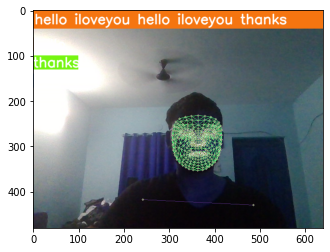

In [48]:
plt.imshow(prob_viz(res, actions, image, colors))

In [56]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image,results)
        
        # 2. Prediction Logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        
        # 3. Visualisation logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Visualisation probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 24ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [=========

1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [=========

1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [=========

thanks
1/1 [==============================] - 0s 19ms/step
thanks
1/1 [==============================] - 0s 21ms/step
thanks
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 18ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [

1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [=========

thanks
1/1 [==============================] - 0s 22ms/step
thanks
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 24ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 28ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 24ms/step
hello
1/1 [=

1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [=========

1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 24ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [=========

1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [=========

In [54]:
cap.release()
cv2.destroyAllWindows()